### Predicting co-players' strategies in simulated Prisoner's Dilemma - online learning with Keras

**The game**

Prisoner's dilemma is the most classic example from the game theory. As a model of real world situations requiring choices about cooperation it has become widely studied model in economics and social sciences. Here i will use generalized, iterated and infinite version of the game without optimal strategy:
- Two players who cannot communicate with each other. Each player chooses either "Cooperate" (C) or "Defect" (D)
- If both cooperate they get reward (R). If both defect, they are punished (P). If one defects it gets temptation payoff (T) and the other one "sucker's" payoff (S)
- T > R > P > S
- The payofs will be represented with the following matrix:

<center><img src="http://www.studycas.com/images/PDGT.jpg" width="400"></img></center>

**In the notebook:**
- Make a new player that learns to predict oponenets strategies based on their type and mimics the same choice. I use Keras to build minimalistic network that will learn as it plays.
- Simulate classic tournament and see how the new player is doing.
- Look at the model loss for each strategy and check how difficult it was to learn it.
- Propose a new way to run repeaded Prisoner's Dilema simulations:
    - open group setup - each round every player can play with any other
    - probability of beeing chosen changes from round to round based on the past choices - "Cooperation" increases the probability while "Defection" decreases it.

____

In [562]:
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import string
import itertools
import random

import keras
from keras.models import Model
from keras.layers import Input, Dense, concatenate

import axelrod as axl
from axelrod import Action, Player
C, D = Action.C, Action.D
import nashpy as nash

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

axl.seed(0)

_____

#### RANDOM GAME

**Game structure**

In [1384]:
# Prisoner's dilemma
A = np.array([[3, 3], [5, 0]])
B = np.array([[0, 5], [1, 1]])
prisoners_dilemma = nash.Game(A, B)

In [1605]:
def simulate_game(game_arch, num_iterations):
    """Accepts any game architecture (from Nashpy) and performs num_iterations of that game"""
    random.seed(99)
    num_strategies = game_arch.payoff_matrices[0].shape[0]
    strategies = np.identity(num_strategies)
    payoffs_list = []
    for _ in range(num_iterations):
        s1 = strategies[np.random.randint(low = 0, high = num_strategies)]
        s2 = strategies[np.random.randint(low = 0, high = num_strategies)]
        payoffs = game_arch[s1, s2]
        payoffs_list.append(payoffs)
    results = np.stack(payoffs_list, axis=0)
    return(results)

**Run**

In [1386]:
random_prisoner = simulate_game(game_arch=prisoners_dilemma, num_iterations=1000)
random_prisoner_df = pd.DataFrame(random_prisoner)

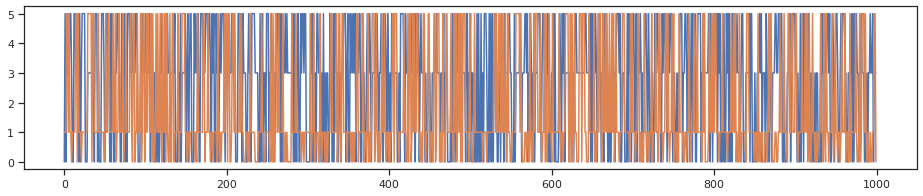

In [1387]:
plt.figure(figsize=(16, 3))
plt.plot(random_prisoner_df)

In [1388]:
random_prisoner_df.sum()

0    2763.0
1    1789.0
dtype: float64

____

#### CLASSIC STRATEGIES

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/IPD_Venn.svg/600px-IPD_Venn.svg.png"></img></center>

- Playing the game at random is probably not the best approach. Luckily there has been many strategies designed to maximize the score in the iterated version of the game. Over 200 of them, together with the whole framework to play tournaments between, are available through **Axelrod** package - [https://axelrod.readthedocs.io/en/stable/index.html](https://axelrod.readthedocs.io/en/stable/index.html)
- For this notebook i select few popular strategies that represent different approaches.

In [719]:
selected_strategies = [axl.Cooperator, axl.Defector, axl.TitForTat, axl.Gambler, axl.AlternatorHunter, axl.Adaptive]
players = [s() for s in selected_strategies]
players_names = [p.name for p in players]
players_vectors = np.identity(len(players))

In [628]:
def match_report(match):
    print("MATCH SUMMARY:")
    print(f"Game info: {match.match_attributes}")
    print(f"Players: {match.players}")
    print(f"Winner: {match.winner()}")
    print(f"Final score: {match.final_score()}")
    print(f"Cooperations: {match.cooperation()}, Normalised cooperation: {match.normalised_cooperation()}")
    print(f"States: {match.state_distribution()}")
    print("----- ")

In [632]:
selected_players = [players[4], players[5]]
match = axl.Match(selected_players, turns=500)
match.play()
match_report(match)

MATCH SUMMARY:
Game info: {'length': 500, 'game': Axelrod game: (R,P,S,T) = (3, 1, 0, 5), 'noise': 0}
Players: [Alternator Hunter, Adaptive]
Winner: Adaptive
Final score: (18, 2488)
Cooperations: (500, 6), Normalised cooperation: (1.0, 0.012)
States: Counter({(C, D): 494, (C, C): 6})
----- 


_____

#### KERAS MODEL

- Let's extend selected classic strategies with one more Player. It will be actively learning agent that tries to predict co-player strategy and always reflets the same choice (~ chameleon strategy so let's call it `Leon`). It can be considered a version of Tit for tat, but instead of direct access to the last oponent's move the model tries to guess the next one.
- With this approach we can potentially adjust strategy choices based on the prediction (here i just mirror the predicted strategy but some form of discrete Q learning could be added in the strategy method).
- Second adventage of this approach it that by looking at the loss of our agent we can check how difficult it is to learn different strategies - estimate their predictability.
- The model is a small MLP accepting one-hot encoded vector of a co-player followed by one hidden layer of 5 units with relu activation and the output layer with sigmoid to decice on Cooperate vs. Defect strategy. 

In [720]:
def minimal_model(num_players):
    partner_input = Input(shape=(num_players,), name="partner_input") 
    l1 = Dense(5, activation="relu")(partner_input)
    strategy_output = Dense(2, activation="sigmoid", name="strategy_output")(l1)
    strategy_model = Model(inputs=partner_input, outputs=strategy_output)
    strategy_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
    return(strategy_model)

In [1389]:
minimal_model(len(players)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
partner_input (InputLayer)   (None, 6)                 0         
_________________________________________________________________
dense_287 (Dense)            (None, 5)                 35        
_________________________________________________________________
strategy_output (Dense)      (None, 2)                 12        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [887]:
class KerasChameleon(Player):
    """
    MLP Keras model that takes oponent name as an input, learns its strategy and reflects it.
    """
    
    name = "leon"
    classifier = {
        "memory_depth": 1,  # Four-Vector = (1.,0.,1.,0.)
        "stochastic": True,
        "makes_use_of": set(),
        "long_run_time": False,
        "inspects_source": False,
        "manipulates_source": False,
        "manipulates_state": False,
    }
    

    def __init__(self, num_players):
        Player.__init__(self)
        self.model = minimal_model(num_players)
        self.loss_history = []
        self.coplayer_history = []

    def strategy(self, opponent: Player) -> Action:
        
        action2input = {'C' : np.array([1,0]), 'D' : np.array([0,1])}
        oponent_vector = players_vectors[players_names.index(opponent.name)]
        input =  oponent_vector.reshape((1, oponent_vector.shape[0]))
        
        # learn on previous experiance
        if opponent.history:
            last_oponent_strategy = action2input[str(opponent.history[-1])]
            output =  last_oponent_strategy.reshape((1, last_oponent_strategy.shape[0]))
            self.model.fit(input, output, epochs=1, batch_size=1, verbose=0)
            self.loss_history.append(self.model.history.history['loss'])
            self.coplayer_history.append(opponent.name)
        
        # predict coplayer strategy
        predictions = self.model.predict(input)
        predicted_strategy = predictions[0]
        predicted_strategy[np.argmax(predicted_strategy)] = 1
        predicted_strategy[np.argmin(predicted_strategy)] = 0
        
        # play the same
        if predicted_strategy[0] == 1: # C
            return C
        else:
            return D

**Test run:**

In [888]:
p1 = axl.Cooperator()
p2 = axl.Defector()
p3 = KerasChameleon(num_players = len(players))

In [889]:
for _ in range(50):
    p3.play(p1)

In [890]:
# Cooperator
p1.history

[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C]

In [891]:
for _ in range(100):
    p3.play(p2)

In [892]:
# Defector
p2.history

[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]

In [893]:
p3.history

[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]

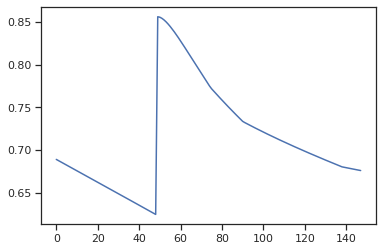

In [894]:
plt.plot(p3.loss_history)

The model learned to reflect Cooperator but **was able to switch strategy after changing coplayer to Defector.**

_____

#### SIMULATING MULTIPLE 1:1 GAMES

By looking at the loss function of newly created player we can estimate difficulty (predictability) of other strategies. Let's simulate multiple random games with subset of classic players and see how quickly our Keras model will be able to predict their future choices.

In [664]:
%%time
random.seed(23)
p1 = KerasChameleon(num_players=len(players))
for _ in range(10000):
    p2 = random.sample(players, 1)[0]
    p1.play(p2)

CPU times: user 51.8 s, sys: 3.81 s, total: 55.6 s
Wall time: 39.8 s


**How difficult it was to learn each strategy?**

<Figure size 1008x504 with 0 Axes>

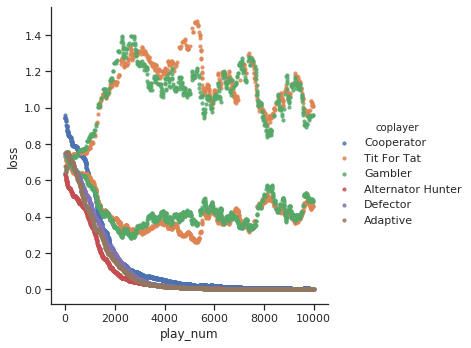

In [665]:
x = list(range(len(p1.loss_history)))
y = [p[0] for p in p1.loss_history]
names = p1.coplayer_history
loss_history = pd.DataFrame({'play_num': x, 'loss': y, 'coplayer': names})

sns.lmplot(x="play_num", y="loss", hue="coplayer", data=loss_history, order=2, ci=None, scatter_kws={"s": 10}, fit_reg=False);

While playing with six different strategies the model was able to learn four of them. It wasn't able to learn Tit For Tat (which swiched its strategy every time prediction went wrong) as well as Gambler that introduces stochasting elements in the decision process.

**Is reflecting learned co-player strategy a god strategy?**

In [666]:
for player in players:
    p1 = KerasChameleon(num_players=len(players))
    selected_players = [p1, player]
    match = axl.Match(selected_players, turns=500)
    match.play()
    match_report(match)

MATCH SUMMARY:
Game info: {'length': 500, 'game': Axelrod game: (R,P,S,T) = (3, 1, 0, 5), 'noise': 0}
Players: [KerasChameleon: 6, Cooperator]
Winner: False
Final score: (1500, 1500)
Cooperations: (500, 500), Normalised cooperation: (1.0, 1.0)
States: Counter({(C, C): 500})
----- 
MATCH SUMMARY:
Game info: {'length': 500, 'game': Axelrod game: (R,P,S,T) = (3, 1, 0, 5), 'noise': 0}
Players: [KerasChameleon: 6, Defector]
Winner: False
Final score: (500, 500)
Cooperations: (0, 0), Normalised cooperation: (0.0, 0.0)
States: Counter({(D, D): 500})
----- 
MATCH SUMMARY:
Game info: {'length': 500, 'game': Axelrod game: (R,P,S,T) = (3, 1, 0, 5), 'noise': 0}
Players: [KerasChameleon: 6, Tit For Tat]
Winner: KerasChameleon: 6
Final score: (504, 499)
Cooperations: (0, 1), Normalised cooperation: (0.0, 0.002)
States: Counter({(D, D): 499, (D, C): 1})
----- 
MATCH SUMMARY:
Game info: {'length': 500, 'game': Axelrod game: (R,P,S,T) = (3, 1, 0, 5), 'noise': 0}
Players: [KerasChameleon: 6, Gambler]
Wi

**Tournament**

In [704]:
selected_strategies = [axl.Cooperator, axl.Defector, axl.TitForTat, axl.Gambler, axl.AlternatorHunter, axl.Adaptive]
players = [s() for s in selected_strategies]
players_names = [p.name for p in players]
print(players_names)

['Cooperator', 'Defector', 'Tit For Tat', 'Gambler', 'Alternator Hunter', 'Adaptive']


In [705]:
players_names.append("leon")
players_vectors = np.identity(len(players_names))
leon = KerasChameleon(num_players=len(players_names))
players.append(leon)
tournament = axl.Tournament(players)
results = tournament.play()












Playing matches:   0%|          | 0/28 [00:00<?, ?it/s]










Playing matches:  25%|██▌       | 7/28 [00:15<00:47,  2.27s/it]










Playing matches:  46%|████▋     | 13/28 [00:31<00:35,  2.39s/it]










Playing matches:  64%|██████▍   | 18/28 [00:47<00:26,  2.62s/it]










Playing matches:  75%|███████▌  | 21/28 [00:47<00:12,  1.85s/it]










Playing matches:  79%|███████▊  | 22/28 [03:35<05:10, 51.67s/it]










Playing matches:  89%|████████▉ | 25/28 [03:54<01:54, 38.01s/it]










Playing matches:  96%|█████████▋| 27/28 [04:14<00:29, 29.64s/it]










Playing matches: 100%|██████████| 28/28 [04:48<00:00, 30.97s/it]










Analysing:   0%|          | 0/25 [00:00<?, ?it/s]










Analysing:   4%|▍         | 1/25 [00:00<00:03,  6.46it/s]










Analysing: 100%|██████████| 25/25 [00:00<00:00, 133.13it/s]

/home/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


<Figure size 1008x504 with 0 Axes>

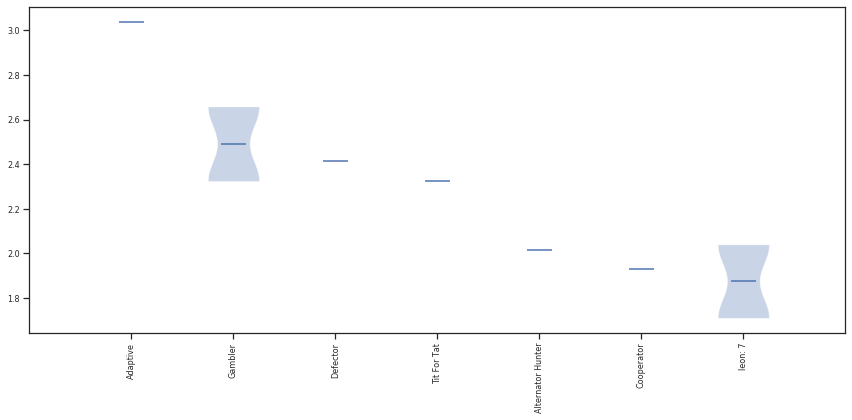

In [706]:
plt.figure(figsize=(14, 7))
plot = axl.Plot(results)
p = plot.boxplot()
p.show()

- In the classic tournament setup players play with one oponent multiple rounds and then start blank with the next one.`Leon` had a hard time to follow other players and ended up last!

_____

### GROUP SIMULATION

Instead of simulating 1:1 metches let's try to play the game as a group:
- all agents interacting with each other while keeping their memory of the previous games (regardless who they played with)
- each turn probability of being chosen is updated based on selected strategy: Cooperation -> increase, Defect -> decreses

**Setup**

In [1320]:
random.seed(1)
selected_strategies = [axl.Cooperator, axl.Defector, axl.TitForTat, axl.Gambler, axl.AlternatorHunter, axl.Adaptive]
players = [s() for s in selected_strategies]
players_names = [p.name for p in players]
print(players_names)

['Cooperator', 'Defector', 'Tit For Tat', 'Gambler', 'Alternator Hunter', 'Adaptive']


In [1331]:
group_size = 15
players_group = random.choices(players, k=group_size)
leon = KerasChameleon(num_players=len(players_group)+1)
players_group.append(leon)
players_names = [players_group[i].name for i in range(len(players_group))]
players_vectors = np.identity(len(players_names))

In [1332]:
print(players_names)

['Gambler', 'Gambler', 'Cooperator', 'Cooperator', 'Tit For Tat', 'Defector', 'Alternator Hunter', 'Alternator Hunter', 'Gambler', 'Gambler', 'Gambler', 'Cooperator', 'Tit For Tat', 'Cooperator', 'Adaptive', 'leon']


In [1425]:
def count_points(choice_1, choice_2):
    if choice_1 == "C" and choice_2 == "C": return (3,3)
    if choice_1 == "C" and choice_2 == "D": return (0,5)
    if choice_1 == "D" and choice_2 == "D": return (1,1)
    if choice_1 == "D" and choice_2 == "C": return (5,0)

In [1466]:
def update_probs(probs):
    """
    Updates probabilities of beening chosen for interaction in a group.
    Cooperating increases and Defecting decreases the probability.
    When both players cooperate probability for other players slightly decreases.
    """
    pool = len(players_names)*prob_unit
    if choice_1 == "D" and choice_2 == "D":
        probs
    elif choice_1 == "C" and choice_2 == "C":
        probs[idx1] += pool/2; probs[idx2] += pool/2
        probs -= prob_unit
    elif choice_1 == "C" and choice_2 == "D":
        probs[idx1] += pool/2; probs[idx2] -= pool/2
    elif choice_1 == "D" and choice_2 == "C":
        probs[idx1] -= pool/2; probs[idx2] += pool/2
    
    if len(probs[probs < 0]) > 0:
        left_pool = sum(probs[probs<0])
        probs[probs < 0] = 0
        probs += left_pool/len(players_names)

**Simulate**

In [1568]:
%%time
random.seed(112)
num_iterations = 1000
recording = []
probs = np.repeat(1/len(players_group), len(players_group)) # start with uniform
probs_history = probs
prob_unit = 0.00005
for i in range(num_iterations):
    idx1, idx2 = np.random.choice(a=range(len(players_group)), size=2, p=probs)
    players_group[idx1].play(players_group[idx2])
    choice_1, choice_2 = [str(players_group[idx1].history[-1]), str(players_group[idx2].history[-1])]
    probs_history = np.vstack([probs_history, probs])
    update_probs(probs)
    score_1, score_2 = count_points(choice_1, choice_2)
    recording.append([i, idx1, idx2,\
                      players_group[idx1].name, players_group[idx2].name,\
                      choice_1, choice_2, score_1, score_2])

CPU times: user 1.18 s, sys: 30.1 ms, total: 1.21 s
Wall time: 1.01 s


**Results**

In [1480]:
recording_df = pd.DataFrame(recording,columns=['num_iter', 'p1_id', 'p2_id', 'p1_type','p2_type',\
                                               "p1_choice", "p2_choice", "p1_score", "p2_score"])
recording_df['cooperation'] = np.where((recording_df['p1_choice'] == "C") & (recording_df['p2_choice'] == "C"), 1, 0)
recording_df.to_csv("sim_15a_10k.csv")

In [1602]:
recording_df.head()

,num_iter,p1_id,p2_id,p1_type,p2_type,p1_choice,p2_choice,p1_score,p2_score,cooperation
0,0,9,2,Gambler,Cooperator,C,C,3,3,1
1,1,1,8,Gambler,Gambler,C,C,3,3,1
2,2,9,4,Gambler,Tit For Tat,C,C,3,3,1
3,3,12,1,Tit For Tat,Gambler,C,C,3,3,1
4,4,11,6,Cooperator,Alternator Hunter,C,C,3,3,1


In [1625]:
edges = recording_df.groupby(['p1_id', 'p2_id'], as_index=False)['cooperation'].agg(['count', 'sum']).reset_index()
p1_df = recording_df[['num_iter', 'p1_id', 'p1_type', 'p1_choice', 'p1_score']]
p2_df = recording_df[['num_iter', 'p2_id', 'p2_type', 'p2_choice', 'p2_score']]
p1_df.columns = ['num_iter', 'id', 'type', 'choice', 'score']
p2_df.columns = ['num_iter', 'id', 'type', 'choice', 'score']
long_edges = pd.concat([p1_df, p2_df])
nodes = long_edges.groupby(['id','type']).agg(['sum', 'mean']).reset_index()

In [1626]:
nodes.sort_values(by=("score","sum"), ascending=False)

id               type num_iter             score          
                               sum        mean   sum      mean
3    3         Cooperator    88828  525.609467   474  2.804734
7    7  Alternator Hunter    80513  485.018072   462  2.783133
13  13         Cooperator    83608  529.164557   435  2.753165
11  11         Cooperator    77590  535.103448   420  2.896552
6    6  Alternator Hunter    66190  497.669173   390  2.932331
10  10            Gambler    69560  526.969697   380  2.878788
9    9            Gambler    63281  475.796992   375  2.819549
15  15               leon    66758  513.523077   373  2.869231
4    4        Tit For Tat    57853  459.150794   359  2.849206
0    0            Gambler    64258  490.519084   358  2.732824
12  12        Tit For Tat    67794  521.492308   353  2.715385
2    2         Cooperator    58515  508.826087   324  2.817391
1    1            Gambler    55256  497.801802   310  2.792793
8    8            Gambler    52655  506.298077   287  2.759615
14  14           Adaptive    26034  406.781250   188  2.937500
5    5           Defector    20307  383.150943   149  2.811321

In [1628]:
(long_edges
 .groupby(["id", "choice"])['choice'].agg(['count'])
 .reset_index()
 .pivot(index='id',columns='choice',values='count')
 .fillna(0)
 .sort_values("C", ascending=False)
)

choice,C,D
id,,
3,169.0,0.0
7,166.0,0.0
13,158.0,0.0
11,145.0,0.0
6,133.0,0.0
15,129.0,1.0
9,124.0,9.0
10,122.0,10.0
12,117.0,13.0


- In the open group set up where players chances of interactions depend on their past choices of strategies `Cooperators` gain huge advenrage while `Defectors` are slowly pushed out of the group.
- `Adaptive` which has been the most successfull in the tournament ends on the last but one position (altough high average score)
- `Leon` performs much better then in the tournament setup. As the model learns to predict others strategies it can adjust its own choices.

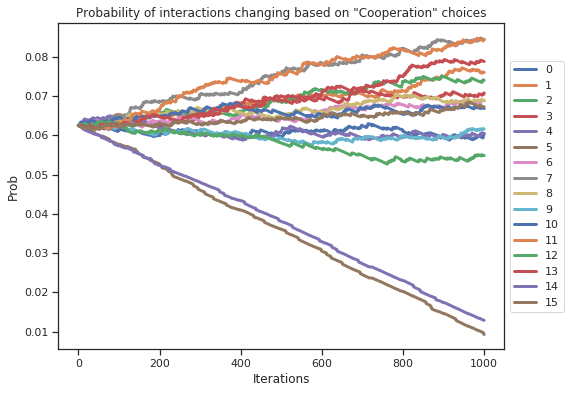

In [1599]:
probs_df = pd.DataFrame(probs_history)
plt.figure(figsize=(8, 6))
plt.plot(probs_df, linewidth=3)
plt.set_cmap('tab20')
plt.title('Probability of interactions changing based on "Cooperation" choices')
plt.xlabel("Iterations"); plt.ylabel("Prob")
plt.legend(probs_df.columns, bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

**Interactions network**

Let's make a graph to visualize cooperations score for each 1:1 relation in the group.

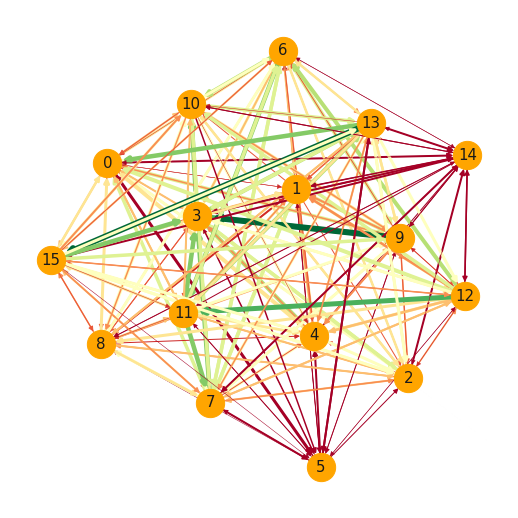

In [1494]:
G=nx.from_pandas_edgelist(edges, source='p1_id', target='p2_id', edge_attr=True, create_using=nx.DiGraph())
weights = edges['count']
cooperations = [int(v) for v in list(edges['sum'])]
node_size = nodes['score']['sum'].values

plt.figure(3,figsize=(7,7)) 
nx.draw(G,
        with_labels=True,
        node_color='orange',
        #node_size = node_size/4,
        node_size=800,
        edge_color=cooperations,
        edge_alpha=cooperations,
        edge_cmap=plt.cm.RdYlGn,
        width=weights/2,
        font_size=15)

#pos = nx.spring_layout(G)
#nx.draw_networkx_nodes(G, pos, nodelist=[15], node_size=800, node_color='orange')

- Each node corresponds to one player, edge size corresponds to number of interactions while their color to the number of cooperative interactions (red -> green).
- Since every turn agents play with different co-partners their strategy depends on the whole group sctucture sampled with their past interactions. As a result all iterated strategies with memory -1 ('lookup' hardcoeded records of the past games) may become less roboust depending on different groups setups.
- Created model is able to assign expected choices to types of players (without unrealistic lookup in their history) and potentially adjust strategy. It shis case it worked mainly as a Cooperators enablers
- When cooperation increses probability of being chosen, Defector is quickly excluded from interactions.

____

<center>THE END</center>